#### experimenting with the effects of superposition on adversarial robustness

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [17]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import einops
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int  # Number of model instances (set to 1 for simplicity)

class Model(nn.Module):
    def __init__(self, 
                  config, 
                  feature_probability: Optional[torch.Tensor] = None,
                  importance: Optional[torch.Tensor] = None,               
                  device=DEVICE):
        super().__init__()
        self.config = config
        self.W = nn.Parameter(torch.empty((config.n_features, config.n_hidden), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_features,), device=device))

        if feature_probability is None:
            feature_probability = torch.ones((config.n_features,), device=device)
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones((config.n_features,), device=device)
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [batch_size, n_features]
        # W: [n_features, n_hidden]
        hidden = torch.matmul(features, self.W)
        out = torch.matmul(hidden, self.W.T)
        out = out + self.b_final
        out = F.relu(out)
        return out

    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.config.n_features), device=self.W.device)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_features), device=self.W.device) <= self.feature_probability,
            feat,
            torch.zeros_like(feat, device=self.W.device),
        )
        return batch

In [19]:
def optimize(model, 
             n_batch=1024,
             steps=5000,
             print_freq=500,
             lr=1e-3,
             l1_lambda=0.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for step in trange(steps):
        opt.zero_grad(set_to_none=True)
        batch = model.generate_batch(n_batch)
        out = model(batch)
        error = (model.importance * (batch - out) ** 2)
        loss = error.mean()
        # Add L1 regularization if needed
        if l1_lambda > 0.0:
            l1_norm = sum(torch.abs(param).sum() for param in model.parameters())
            loss = loss + l1_lambda * l1_norm
        loss.backward()
        opt.step()
        if step % print_freq == 0 or step == steps - 1:
            print(f"Step {step}/{steps}, Loss: {loss.item():.6f}")

In [20]:
# fast gradient sign method
def fgsm_attack(model, data, epsilon, importance):
    data.requires_grad = True
    output = model(data)
    loss = (importance * (data - output) ** 2).mean()
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    # Generate adversarial examples
    perturbed_data = data + epsilon * data_grad.sign()
    # Clip data to valid range
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

In [21]:
def pgd_attack(model, data, epsilon, alpha, num_iter, importance):
    original_data = data.clone().detach()
    perturbed_data = data.clone().detach()
    for i in range(num_iter):
        perturbed_data.requires_grad = True
        output = model(perturbed_data)
        loss = (importance * (original_data - output) ** 2).mean()
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_data.grad.data
        perturbed_data = perturbed_data + alpha * data_grad.sign()
        # Project back into the epsilon-ball
        perturbed_data = torch.max(torch.min(perturbed_data, original_data + epsilon), original_data - epsilon)
        # Clip data to valid range
        perturbed_data = torch.clamp(perturbed_data, 0, 1).detach()
    return perturbed_data

In [23]:
def evaluate_adversarial(model, importance, epsilon=0.1, n_batch=1024, attack_type='fgsm'):
    data = model.generate_batch(n_batch)
    if attack_type == 'fgsm':
        adv_data = fgsm_attack(model, data, epsilon, importance)
    elif attack_type == 'pgd':
        alpha = epsilon / 4  # Step size
        num_iter = 10  # Number of iterations
        adv_data = pgd_attack(model, data, epsilon, alpha, num_iter, importance)
    else:
        raise ValueError("Unsupported attack type")
    output = model(adv_data)
    loss = (importance * (data - output) ** 2).mean()
    return loss.item()

In [24]:
# measure superposition in the model
def measure_superposition(model):
    W = model.W.detach()  # [n_features, n_hidden]
    norms = torch.linalg.norm(W, dim=-1, keepdim=True)  # [n_features, 1]
    W_normalized = W / (norms + 1e-6)
    interference = torch.abs(torch.matmul(W_normalized, W_normalized.T))
    interference = interference - torch.diag(torch.diag(interference))  # Remove self-interference
    avg_interference = interference.mean().item()
    return avg_interference


In [25]:
'''
by changing the number of hidden units and the l1 regularization parameter, we can see how the model's robustness and superposition change as we increase the number of hidden units.
'''

def run_experiment(n_features=100, n_hidden_list=[20, 40, 60, 80, 100, 120], l1_lambda_list=[0.0], attack_type='fgsm'):
    results = []
    for l1_lambda in l1_lambda_list:
        for n_hidden in n_hidden_list:
            print(f"\nTraining model with n_hidden = {n_hidden}, l1_lambda = {l1_lambda}")
            config = Config(
                n_features=n_features,
                n_hidden=n_hidden,
                n_instances=1,
            )
            feature_probability = torch.ones((n_features,), device=DEVICE) * 0.5  # 50% sparsity
            importance = torch.ones((n_features,), device=DEVICE)
            model = Model(
                config=config,
                device=DEVICE,
                feature_probability=feature_probability,
                importance=importance,
            )
            optimize(model, steps=5000, lr=1e-3, l1_lambda=l1_lambda)
            loss_clean = evaluate_adversarial(model, importance, epsilon=0.0, attack_type=attack_type)
            loss_adv = evaluate_adversarial(model, importance, epsilon=0.1, attack_type=attack_type)
            superposition_measure = measure_superposition(model)
            results.append({
                'n_hidden': n_hidden,
                'l1_lambda': l1_lambda,
                'loss_clean': loss_clean,
                'loss_adv': loss_adv,
                'superposition': superposition_measure,
                'attack_type': attack_type,
            })
    return results

In [26]:
n_features = 100
n_hidden_list = [20, 40, 60, 80, 100, 120]
l1_lambda_list = [0.0, 1e-5, 1e-4, 1e-3]
results_fgsm = run_experiment(n_features=n_features, n_hidden_list=n_hidden_list, l1_lambda_list=l1_lambda_list, attack_type='fgsm')



Training model with n_hidden = 20, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.114465
Step 500/5000, Loss: 0.082506
Step 1000/5000, Loss: 0.082218
Step 1500/5000, Loss: 0.079828
Step 2000/5000, Loss: 0.078220
Step 2500/5000, Loss: 0.077816
Step 3000/5000, Loss: 0.077468
Step 3500/5000, Loss: 0.078236
Step 4000/5000, Loss: 0.078433
Step 4500/5000, Loss: 0.077656
Step 4999/5000, Loss: 0.078148

Training model with n_hidden = 40, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.124406
Step 500/5000, Loss: 0.058910
Step 1000/5000, Loss: 0.058532
Step 1500/5000, Loss: 0.056705
Step 2000/5000, Loss: 0.053090
Step 2500/5000, Loss: 0.052087
Step 3000/5000, Loss: 0.051363
Step 3500/5000, Loss: 0.050967
Step 4000/5000, Loss: 0.051442
Step 4500/5000, Loss: 0.051708
Step 4999/5000, Loss: 0.051952

Training model with n_hidden = 60, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.122800
Step 500/5000, Loss: 0.036115
Step 1000/5000, Loss: 0.035767
Step 1500/5000, Loss: 0.032335
Step 2000/5000, Loss: 0.031466
Step 2500/5000, Loss: 0.031351
Step 3000/5000, Loss: 0.030664
Step 3500/5000, Loss: 0.030356
Step 4000/5000, Loss: 0.030408
Step 4500/5000, Loss: 0.030643
Step 4999/5000, Loss: 0.031017

Training model with n_hidden = 80, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.123630
Step 500/5000, Loss: 0.016328
Step 1000/5000, Loss: 0.015711
Step 1500/5000, Loss: 0.016117
Step 2000/5000, Loss: 0.015183
Step 2500/5000, Loss: 0.015319
Step 3000/5000, Loss: 0.014852
Step 3500/5000, Loss: 0.015227
Step 4000/5000, Loss: 0.014555
Step 4500/5000, Loss: 0.014987
Step 4999/5000, Loss: 0.014883

Training model with n_hidden = 100, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.101971
Step 500/5000, Loss: 0.000307
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 120, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.115601
Step 500/5000, Loss: 0.000001
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000003
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000001

Training model with n_hidden = 20, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.111180
Step 500/5000, Loss: 0.083577
Step 1000/5000, Loss: 0.083813
Step 1500/5000, Loss: 0.081357
Step 2000/5000, Loss: 0.080212
Step 2500/5000, Loss: 0.079148
Step 3000/5000, Loss: 0.079656
Step 3500/5000, Loss: 0.078412
Step 4000/5000, Loss: 0.078352
Step 4500/5000, Loss: 0.079678
Step 4999/5000, Loss: 0.079978

Training model with n_hidden = 40, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.129879
Step 500/5000, Loss: 0.063012
Step 1000/5000, Loss: 0.061767
Step 1500/5000, Loss: 0.060811
Step 2000/5000, Loss: 0.059149
Step 2500/5000, Loss: 0.056143
Step 3000/5000, Loss: 0.055459
Step 3500/5000, Loss: 0.054810
Step 4000/5000, Loss: 0.054357
Step 4500/5000, Loss: 0.054659
Step 4999/5000, Loss: 0.054226

Training model with n_hidden = 60, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.110947
Step 500/5000, Loss: 0.041516
Step 1000/5000, Loss: 0.040260
Step 1500/5000, Loss: 0.038118
Step 2000/5000, Loss: 0.036246
Step 2500/5000, Loss: 0.036045
Step 3000/5000, Loss: 0.034861
Step 3500/5000, Loss: 0.035348
Step 4000/5000, Loss: 0.034600
Step 4500/5000, Loss: 0.033819
Step 4999/5000, Loss: 0.033745

Training model with n_hidden = 80, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.114171
Step 500/5000, Loss: 0.022810
Step 1000/5000, Loss: 0.022059
Step 1500/5000, Loss: 0.021442
Step 2000/5000, Loss: 0.020929
Step 2500/5000, Loss: 0.020535
Step 3000/5000, Loss: 0.020024
Step 3500/5000, Loss: 0.019828
Step 4000/5000, Loss: 0.019646
Step 4500/5000, Loss: 0.019348
Step 4999/5000, Loss: 0.019279

Training model with n_hidden = 100, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.099652
Step 500/5000, Loss: 0.007416
Step 1000/5000, Loss: 0.006589
Step 1500/5000, Loss: 0.005928
Step 2000/5000, Loss: 0.005451
Step 2500/5000, Loss: 0.005034
Step 3000/5000, Loss: 0.004485
Step 3500/5000, Loss: 0.003179
Step 4000/5000, Loss: 0.001650
Step 4500/5000, Loss: 0.001237
Step 4999/5000, Loss: 0.001115

Training model with n_hidden = 120, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.139450
Step 500/5000, Loss: 0.008093
Step 1000/5000, Loss: 0.007174
Step 1500/5000, Loss: 0.006404
Step 2000/5000, Loss: 0.005782
Step 2500/5000, Loss: 0.005257
Step 3000/5000, Loss: 0.004630
Step 3500/5000, Loss: 0.003623
Step 4000/5000, Loss: 0.001998
Step 4500/5000, Loss: 0.001347
Step 4999/5000, Loss: 0.001192

Training model with n_hidden = 20, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.130560
Step 500/5000, Loss: 0.091239
Step 1000/5000, Loss: 0.086438
Step 1500/5000, Loss: 0.084798
Step 2000/5000, Loss: 0.084534
Step 2500/5000, Loss: 0.084000
Step 3000/5000, Loss: 0.084330
Step 3500/5000, Loss: 0.084907
Step 4000/5000, Loss: 0.084473
Step 4500/5000, Loss: 0.084932
Step 4999/5000, Loss: 0.083655

Training model with n_hidden = 40, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.141706
Step 500/5000, Loss: 0.078328
Step 1000/5000, Loss: 0.070173
Step 1500/5000, Loss: 0.065091
Step 2000/5000, Loss: 0.063428
Step 2500/5000, Loss: 0.062243
Step 3000/5000, Loss: 0.061682
Step 3500/5000, Loss: 0.061233
Step 4000/5000, Loss: 0.061517
Step 4500/5000, Loss: 0.061190
Step 4999/5000, Loss: 0.061750

Training model with n_hidden = 60, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.161724
Step 500/5000, Loss: 0.066942
Step 1000/5000, Loss: 0.054158
Step 1500/5000, Loss: 0.045955
Step 2000/5000, Loss: 0.043308
Step 2500/5000, Loss: 0.041607
Step 3000/5000, Loss: 0.041359
Step 3500/5000, Loss: 0.041023
Step 4000/5000, Loss: 0.041629
Step 4500/5000, Loss: 0.040825
Step 4999/5000, Loss: 0.041337

Training model with n_hidden = 80, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.163938
Step 500/5000, Loss: 0.056725
Step 1000/5000, Loss: 0.038237
Step 1500/5000, Loss: 0.029658
Step 2000/5000, Loss: 0.026677
Step 2500/5000, Loss: 0.025414
Step 3000/5000, Loss: 0.025375
Step 3500/5000, Loss: 0.025524
Step 4000/5000, Loss: 0.025607
Step 4500/5000, Loss: 0.025809
Step 4999/5000, Loss: 0.026113

Training model with n_hidden = 100, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.209174
Step 500/5000, Loss: 0.052841
Step 1000/5000, Loss: 0.038624
Step 1500/5000, Loss: 0.019867
Step 2000/5000, Loss: 0.012407
Step 2500/5000, Loss: 0.010820
Step 3000/5000, Loss: 0.010487
Step 3500/5000, Loss: 0.010209
Step 4000/5000, Loss: 0.010081
Step 4500/5000, Loss: 0.010079
Step 4999/5000, Loss: 0.010080

Training model with n_hidden = 120, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.191910
Step 500/5000, Loss: 0.048889
Step 1000/5000, Loss: 0.022145
Step 1500/5000, Loss: 0.012652
Step 2000/5000, Loss: 0.010968
Step 2500/5000, Loss: 0.010519
Step 3000/5000, Loss: 0.010122
Step 3500/5000, Loss: 0.010099
Step 4000/5000, Loss: 0.010101
Step 4500/5000, Loss: 0.010100
Step 4999/5000, Loss: 0.010100

Training model with n_hidden = 20, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.309782
Step 500/5000, Loss: 0.116353
Step 1000/5000, Loss: 0.112696
Step 1500/5000, Loss: 0.112463
Step 2000/5000, Loss: 0.112133
Step 2500/5000, Loss: 0.111671
Step 3000/5000, Loss: 0.112935
Step 3500/5000, Loss: 0.112296
Step 4000/5000, Loss: 0.112533
Step 4500/5000, Loss: 0.111919
Step 4999/5000, Loss: 0.112577

Training model with n_hidden = 40, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.472180
Step 500/5000, Loss: 0.117781
Step 1000/5000, Loss: 0.111303
Step 1500/5000, Loss: 0.110896
Step 2000/5000, Loss: 0.111363
Step 2500/5000, Loss: 0.110984
Step 3000/5000, Loss: 0.110746
Step 3500/5000, Loss: 0.111019
Step 4000/5000, Loss: 0.111694
Step 4500/5000, Loss: 0.110687
Step 4999/5000, Loss: 0.110609

Training model with n_hidden = 60, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.659253
Step 500/5000, Loss: 0.116814
Step 1000/5000, Loss: 0.111351
Step 1500/5000, Loss: 0.110664
Step 2000/5000, Loss: 0.111273
Step 2500/5000, Loss: 0.111035
Step 3000/5000, Loss: 0.111189
Step 3500/5000, Loss: 0.111241
Step 4000/5000, Loss: 0.110902
Step 4500/5000, Loss: 0.111420
Step 4999/5000, Loss: 0.110977

Training model with n_hidden = 80, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.774492
Step 500/5000, Loss: 0.117733
Step 1000/5000, Loss: 0.112444
Step 1500/5000, Loss: 0.111728
Step 2000/5000, Loss: 0.111639
Step 2500/5000, Loss: 0.112488
Step 3000/5000, Loss: 0.111376
Step 3500/5000, Loss: 0.112102
Step 4000/5000, Loss: 0.111870
Step 4500/5000, Loss: 0.111843
Step 4999/5000, Loss: 0.111748

Training model with n_hidden = 100, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.900204
Step 500/5000, Loss: 0.118630
Step 1000/5000, Loss: 0.112783
Step 1500/5000, Loss: 0.111316
Step 2000/5000, Loss: 0.111800
Step 2500/5000, Loss: 0.111598
Step 3000/5000, Loss: 0.111462
Step 3500/5000, Loss: 0.112073
Step 4000/5000, Loss: 0.112521
Step 4500/5000, Loss: 0.111351
Step 4999/5000, Loss: 0.112369

Training model with n_hidden = 120, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.005609
Step 500/5000, Loss: 0.117084
Step 1000/5000, Loss: 0.112216
Step 1500/5000, Loss: 0.111627
Step 2000/5000, Loss: 0.111724
Step 2500/5000, Loss: 0.112334
Step 3000/5000, Loss: 0.111488
Step 3500/5000, Loss: 0.112624
Step 4000/5000, Loss: 0.111959
Step 4500/5000, Loss: 0.111801
Step 4999/5000, Loss: 0.111682


In [28]:
import pandas as pd

df_results_fgsm = pd.DataFrame(results_fgsm)

In [29]:
print("\nResults with FGSM Attack:")
display(df_results_fgsm)


Results with FGSM Attack:


,n_hidden,l1_lambda,loss_clean,loss_adv,superposition,attack_type
0,20,0.00000,7.834062e-02,0.079978,0.386791,fgsm
1,40,0.00000,5.176623e-02,0.053508,0.060926,fgsm
2,60,0.00000,3.100025e-02,0.032329,0.015911,fgsm
3,80,0.00000,1.529017e-02,0.017331,0.019716,fgsm
4,100,0.00000,1.250535e-10,0.005577,0.000001,fgsm
5,120,0.00000,5.648365e-07,0.009501,0.000056,fgsm
6,20,0.00001,7.830914e-02,0.079708,0.388384,fgsm
7,40,0.00001,5.172765e-02,0.053219,0.060578,fgsm
8,60,0.00001,3.082087e-02,0.032097,0.015098,fgsm
9,80,0.00001,1.533855e-02,0.018027,0.024608,fgsm


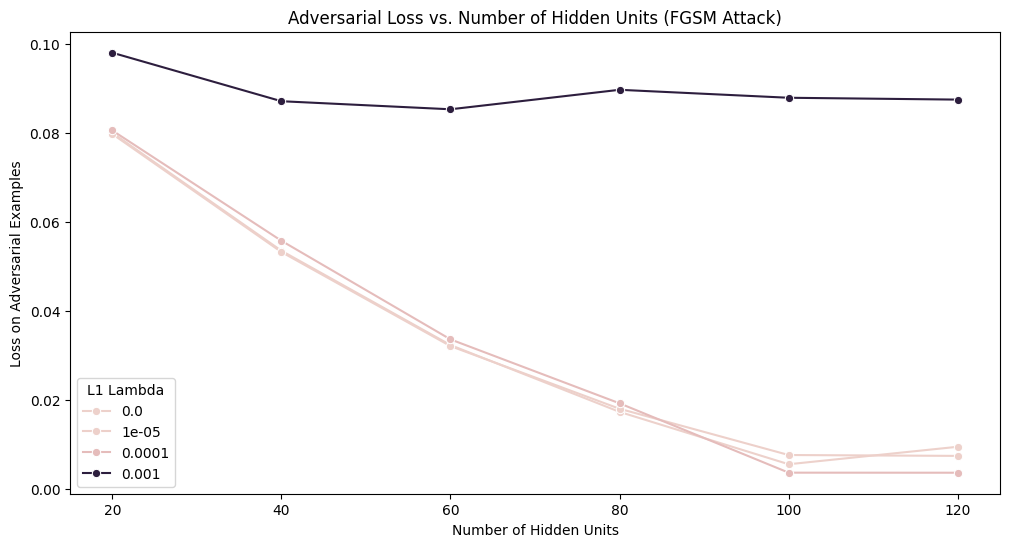

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='n_hidden', y='loss_adv', hue='l1_lambda', data=df_results_fgsm, marker='o')
plt.title('Adversarial Loss vs. Number of Hidden Units (FGSM Attack)')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Loss on Adversarial Examples')
plt.legend(title='L1 Lambda')
plt.show()

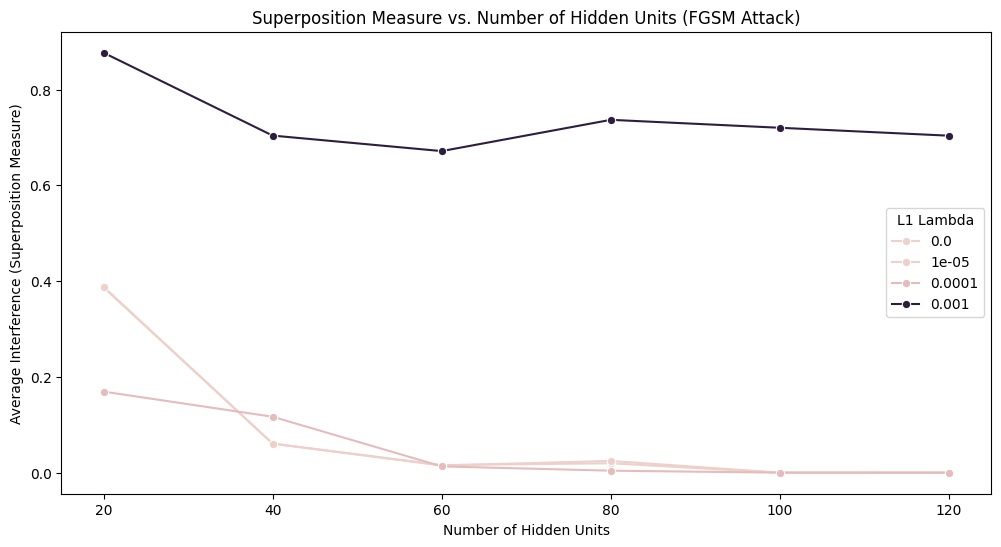

In [31]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='n_hidden', y='superposition', hue='l1_lambda', data=df_results_fgsm, marker='o')
plt.title('Superposition Measure vs. Number of Hidden Units (FGSM Attack)')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Interference (Superposition Measure)')
plt.legend(title='L1 Lambda')
plt.show()


In [32]:
results_pgd = run_experiment(n_features=n_features, n_hidden_list=n_hidden_list, l1_lambda_list=l1_lambda_list, attack_type='pgd')



Training model with n_hidden = 20, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.110167
Step 500/5000, Loss: 0.082850
Step 1000/5000, Loss: 0.082267
Step 1500/5000, Loss: 0.079760
Step 2000/5000, Loss: 0.078622
Step 2500/5000, Loss: 0.077817
Step 3000/5000, Loss: 0.078435
Step 3500/5000, Loss: 0.078357
Step 4000/5000, Loss: 0.078748
Step 4500/5000, Loss: 0.078286
Step 4999/5000, Loss: 0.077936

Training model with n_hidden = 40, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.097856
Step 500/5000, Loss: 0.058840
Step 1000/5000, Loss: 0.057961
Step 1500/5000, Loss: 0.054954
Step 2000/5000, Loss: 0.051805
Step 2500/5000, Loss: 0.051245
Step 3000/5000, Loss: 0.051754
Step 3500/5000, Loss: 0.051920
Step 4000/5000, Loss: 0.052550
Step 4500/5000, Loss: 0.051260
Step 4999/5000, Loss: 0.052259

Training model with n_hidden = 60, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.086611
Step 500/5000, Loss: 0.036678
Step 1000/5000, Loss: 0.033411
Step 1500/5000, Loss: 0.031011
Step 2000/5000, Loss: 0.030408
Step 2500/5000, Loss: 0.031011
Step 3000/5000, Loss: 0.029931
Step 3500/5000, Loss: 0.030104
Step 4000/5000, Loss: 0.031152
Step 4500/5000, Loss: 0.030271
Step 4999/5000, Loss: 0.030354

Training model with n_hidden = 80, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.100595
Step 500/5000, Loss: 0.016027
Step 1000/5000, Loss: 0.015534
Step 1500/5000, Loss: 0.015500
Step 2000/5000, Loss: 0.015181
Step 2500/5000, Loss: 0.015024
Step 3000/5000, Loss: 0.015255
Step 3500/5000, Loss: 0.015107
Step 4000/5000, Loss: 0.015076
Step 4500/5000, Loss: 0.015014
Step 4999/5000, Loss: 0.014900

Training model with n_hidden = 100, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.089031
Step 500/5000, Loss: 0.000002
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000008
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 120, l1_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.129535
Step 500/5000, Loss: 0.000002
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 20, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.114196
Step 500/5000, Loss: 0.084517
Step 1000/5000, Loss: 0.083157
Step 1500/5000, Loss: 0.081194
Step 2000/5000, Loss: 0.080144
Step 2500/5000, Loss: 0.079859
Step 3000/5000, Loss: 0.079434
Step 3500/5000, Loss: 0.079336
Step 4000/5000, Loss: 0.079408
Step 4500/5000, Loss: 0.079252
Step 4999/5000, Loss: 0.079077

Training model with n_hidden = 40, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.110387
Step 500/5000, Loss: 0.062574
Step 1000/5000, Loss: 0.061707
Step 1500/5000, Loss: 0.059619
Step 2000/5000, Loss: 0.057473
Step 2500/5000, Loss: 0.054803
Step 3000/5000, Loss: 0.054634
Step 3500/5000, Loss: 0.054591
Step 4000/5000, Loss: 0.054490
Step 4500/5000, Loss: 0.054036
Step 4999/5000, Loss: 0.053551

Training model with n_hidden = 60, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.138339
Step 500/5000, Loss: 0.041721
Step 1000/5000, Loss: 0.040474
Step 1500/5000, Loss: 0.038858
Step 2000/5000, Loss: 0.036806
Step 2500/5000, Loss: 0.035622
Step 3000/5000, Loss: 0.034598
Step 3500/5000, Loss: 0.034412
Step 4000/5000, Loss: 0.034467
Step 4500/5000, Loss: 0.034204
Step 4999/5000, Loss: 0.033970

Training model with n_hidden = 80, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.115316
Step 500/5000, Loss: 0.022697
Step 1000/5000, Loss: 0.022042
Step 1500/5000, Loss: 0.021252
Step 2000/5000, Loss: 0.020765
Step 2500/5000, Loss: 0.020405
Step 3000/5000, Loss: 0.020322
Step 3500/5000, Loss: 0.019952
Step 4000/5000, Loss: 0.019801
Step 4500/5000, Loss: 0.019687
Step 4999/5000, Loss: 0.019337

Training model with n_hidden = 100, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.144199
Step 500/5000, Loss: 0.007690
Step 1000/5000, Loss: 0.007039
Step 1500/5000, Loss: 0.006424
Step 2000/5000, Loss: 0.005910
Step 2500/5000, Loss: 0.005481
Step 3000/5000, Loss: 0.005054
Step 3500/5000, Loss: 0.004597
Step 4000/5000, Loss: 0.003929
Step 4500/5000, Loss: 0.002706
Step 4999/5000, Loss: 0.001581

Training model with n_hidden = 120, l1_lambda = 1e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.127977
Step 500/5000, Loss: 0.008118
Step 1000/5000, Loss: 0.007200
Step 1500/5000, Loss: 0.006448
Step 2000/5000, Loss: 0.005812
Step 2500/5000, Loss: 0.005266
Step 3000/5000, Loss: 0.004622
Step 3500/5000, Loss: 0.003315
Step 4000/5000, Loss: 0.001850
Step 4500/5000, Loss: 0.001285
Step 4999/5000, Loss: 0.001146

Training model with n_hidden = 20, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.135200
Step 500/5000, Loss: 0.091202
Step 1000/5000, Loss: 0.087573
Step 1500/5000, Loss: 0.085938
Step 2000/5000, Loss: 0.085446
Step 2500/5000, Loss: 0.084507
Step 3000/5000, Loss: 0.083934
Step 3500/5000, Loss: 0.084489
Step 4000/5000, Loss: 0.084082
Step 4500/5000, Loss: 0.083171
Step 4999/5000, Loss: 0.084264

Training model with n_hidden = 40, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.135348
Step 500/5000, Loss: 0.077109
Step 1000/5000, Loss: 0.069474
Step 1500/5000, Loss: 0.063511
Step 2000/5000, Loss: 0.062421
Step 2500/5000, Loss: 0.061324
Step 3000/5000, Loss: 0.061539
Step 3500/5000, Loss: 0.060849
Step 4000/5000, Loss: 0.061623
Step 4500/5000, Loss: 0.062045
Step 4999/5000, Loss: 0.061598

Training model with n_hidden = 60, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.154697
Step 500/5000, Loss: 0.066844
Step 1000/5000, Loss: 0.054626
Step 1500/5000, Loss: 0.047572
Step 2000/5000, Loss: 0.043847
Step 2500/5000, Loss: 0.043107
Step 3000/5000, Loss: 0.042969
Step 3500/5000, Loss: 0.042488
Step 4000/5000, Loss: 0.042005
Step 4500/5000, Loss: 0.041687
Step 4999/5000, Loss: 0.041835

Training model with n_hidden = 80, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.186109
Step 500/5000, Loss: 0.059705
Step 1000/5000, Loss: 0.044703
Step 1500/5000, Loss: 0.031493
Step 2000/5000, Loss: 0.028299
Step 2500/5000, Loss: 0.027184
Step 3000/5000, Loss: 0.026045
Step 3500/5000, Loss: 0.025804
Step 4000/5000, Loss: 0.025091
Step 4500/5000, Loss: 0.025798
Step 4999/5000, Loss: 0.025552

Training model with n_hidden = 100, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.214741
Step 500/5000, Loss: 0.052766
Step 1000/5000, Loss: 0.036385
Step 1500/5000, Loss: 0.016254
Step 2000/5000, Loss: 0.012129
Step 2500/5000, Loss: 0.010770
Step 3000/5000, Loss: 0.010274
Step 3500/5000, Loss: 0.010109
Step 4000/5000, Loss: 0.010080
Step 4500/5000, Loss: 0.010080
Step 4999/5000, Loss: 0.010079

Training model with n_hidden = 120, l1_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.211108
Step 500/5000, Loss: 0.051662
Step 1000/5000, Loss: 0.026755
Step 1500/5000, Loss: 0.012736
Step 2000/5000, Loss: 0.011014
Step 2500/5000, Loss: 0.010479
Step 3000/5000, Loss: 0.010135
Step 3500/5000, Loss: 0.010101
Step 4000/5000, Loss: 0.010101
Step 4500/5000, Loss: 0.010099
Step 4999/5000, Loss: 0.010102

Training model with n_hidden = 20, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.320419
Step 500/5000, Loss: 0.115241
Step 1000/5000, Loss: 0.112025
Step 1500/5000, Loss: 0.111105
Step 2000/5000, Loss: 0.111913
Step 2500/5000, Loss: 0.111236
Step 3000/5000, Loss: 0.111162
Step 3500/5000, Loss: 0.111712
Step 4000/5000, Loss: 0.111970
Step 4500/5000, Loss: 0.111691
Step 4999/5000, Loss: 0.111253

Training model with n_hidden = 40, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.488869
Step 500/5000, Loss: 0.116616
Step 1000/5000, Loss: 0.112101
Step 1500/5000, Loss: 0.110970
Step 2000/5000, Loss: 0.111886
Step 2500/5000, Loss: 0.111238
Step 3000/5000, Loss: 0.112051
Step 3500/5000, Loss: 0.111985
Step 4000/5000, Loss: 0.111672
Step 4500/5000, Loss: 0.111469
Step 4999/5000, Loss: 0.111735

Training model with n_hidden = 60, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.623110
Step 500/5000, Loss: 0.116894
Step 1000/5000, Loss: 0.111450
Step 1500/5000, Loss: 0.111599
Step 2000/5000, Loss: 0.110809
Step 2500/5000, Loss: 0.110842
Step 3000/5000, Loss: 0.111576
Step 3500/5000, Loss: 0.110827
Step 4000/5000, Loss: 0.110850
Step 4500/5000, Loss: 0.111069
Step 4999/5000, Loss: 0.111337

Training model with n_hidden = 80, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.768277
Step 500/5000, Loss: 0.116731
Step 1000/5000, Loss: 0.112061
Step 1500/5000, Loss: 0.111745
Step 2000/5000, Loss: 0.111205
Step 2500/5000, Loss: 0.111523
Step 3000/5000, Loss: 0.111803
Step 3500/5000, Loss: 0.112162
Step 4000/5000, Loss: 0.111675
Step 4500/5000, Loss: 0.112166
Step 4999/5000, Loss: 0.111605

Training model with n_hidden = 100, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.914847
Step 500/5000, Loss: 0.116288
Step 1000/5000, Loss: 0.112423
Step 1500/5000, Loss: 0.112786
Step 2000/5000, Loss: 0.112060
Step 2500/5000, Loss: 0.112471
Step 3000/5000, Loss: 0.111941
Step 3500/5000, Loss: 0.112244
Step 4000/5000, Loss: 0.112804
Step 4500/5000, Loss: 0.112877
Step 4999/5000, Loss: 0.112247

Training model with n_hidden = 120, l1_lambda = 0.001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.035306
Step 500/5000, Loss: 0.119078
Step 1000/5000, Loss: 0.112156
Step 1500/5000, Loss: 0.112144
Step 2000/5000, Loss: 0.112202
Step 2500/5000, Loss: 0.112039
Step 3000/5000, Loss: 0.111864
Step 3500/5000, Loss: 0.112345
Step 4000/5000, Loss: 0.112187
Step 4500/5000, Loss: 0.112491
Step 4999/5000, Loss: 0.113636


In [33]:
df_results_pgd = pd.DataFrame(results_pgd)

print("\nResults with PGD Attack:")
display(df_results_pgd)


Results with PGD Attack:


,n_hidden,l1_lambda,loss_clean,loss_adv,superposition,attack_type
0,20,0.00000,7.790068e-02,0.090089,0.385932,pgd
1,40,0.00000,5.150755e-02,0.066167,0.060899,pgd
2,60,0.00000,3.100521e-02,0.046083,0.015705,pgd
3,80,0.00000,1.509725e-02,0.028387,0.019771,pgd
4,100,0.00000,2.140367e-07,0.009615,0.000029,pgd
5,120,0.00000,1.237663e-07,0.009471,0.000034,pgd
6,20,0.00001,7.761912e-02,0.087836,0.388487,pgd
7,40,0.00001,5.176629e-02,0.066121,0.060761,pgd
8,60,0.00001,3.051764e-02,0.046220,0.015463,pgd
9,80,0.00001,1.545070e-02,0.028192,0.024669,pgd


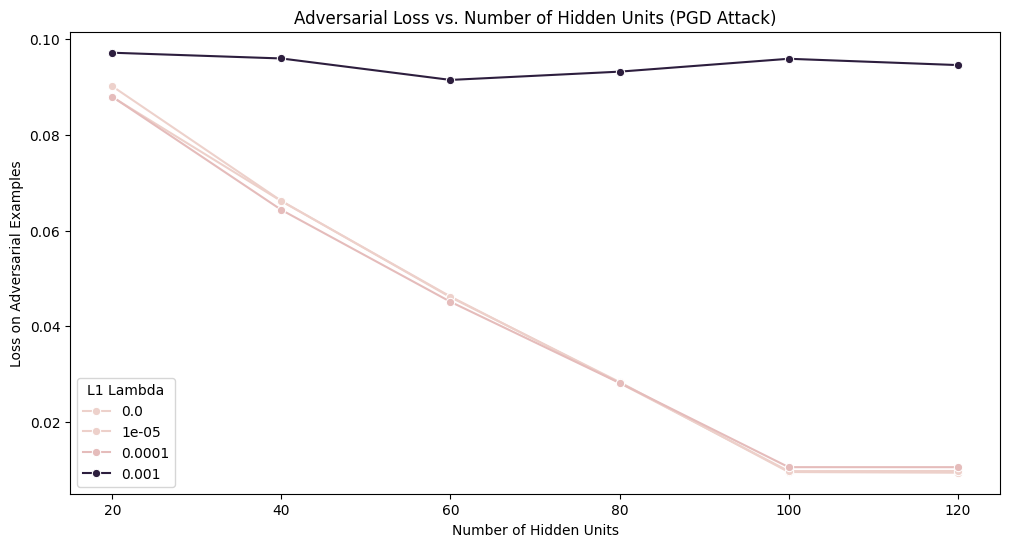

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='n_hidden', y='loss_adv', hue='l1_lambda', data=df_results_pgd, marker='o')
plt.title('Adversarial Loss vs. Number of Hidden Units (PGD Attack)')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Loss on Adversarial Examples')
plt.legend(title='L1 Lambda')
plt.show()

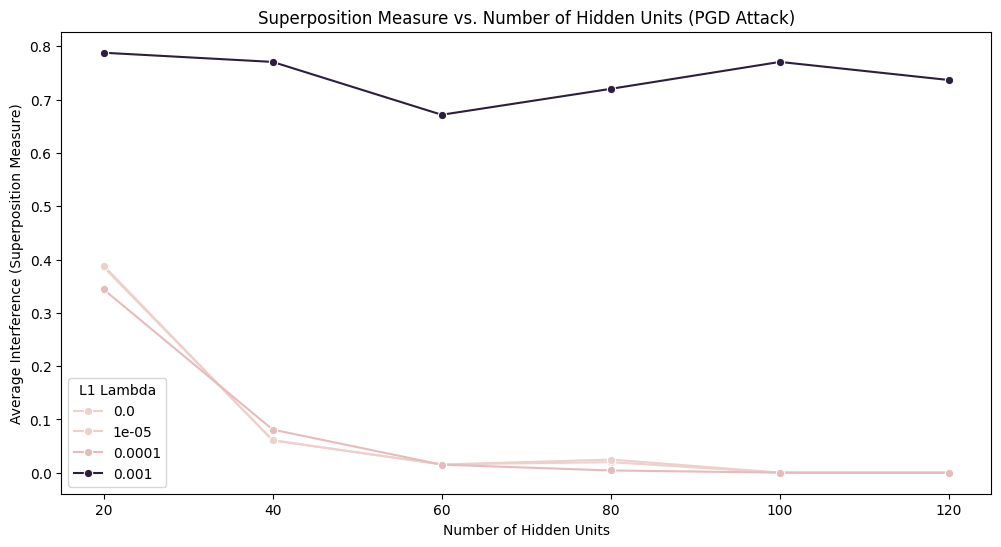

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='n_hidden', y='superposition', hue='l1_lambda', data=df_results_pgd, marker='o')
plt.title('Superposition Measure vs. Number of Hidden Units (PGD Attack)')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Interference (Superposition Measure)')
plt.legend(title='L1 Lambda')
plt.show()

In [36]:
def plot_interference_heatmap(model, title='Interference Heatmap'):
    W = model.W.detach()  # [n_features, n_hidden]
    norms = torch.linalg.norm(W, dim=-1, keepdim=True)  # [n_features, 1]
    W_normalized = W / (norms + 1e-6)
    interference = torch.abs(torch.matmul(W_normalized, W_normalized.T))
    interference = interference - torch.diag(torch.diag(interference))  # Remove self-interference
    plt.figure(figsize=(8, 6))
    sns.heatmap(interference.cpu().numpy(), cmap='viridis')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.113870
Step 500/5000, Loss: 0.082780
Step 1000/5000, Loss: 0.081335
Step 1500/5000, Loss: 0.080791
Step 2000/5000, Loss: 0.079566
Step 2500/5000, Loss: 0.078209
Step 3000/5000, Loss: 0.077669
Step 3500/5000, Loss: 0.078029
Step 4000/5000, Loss: 0.077938
Step 4500/5000, Loss: 0.078150
Step 4999/5000, Loss: 0.078355


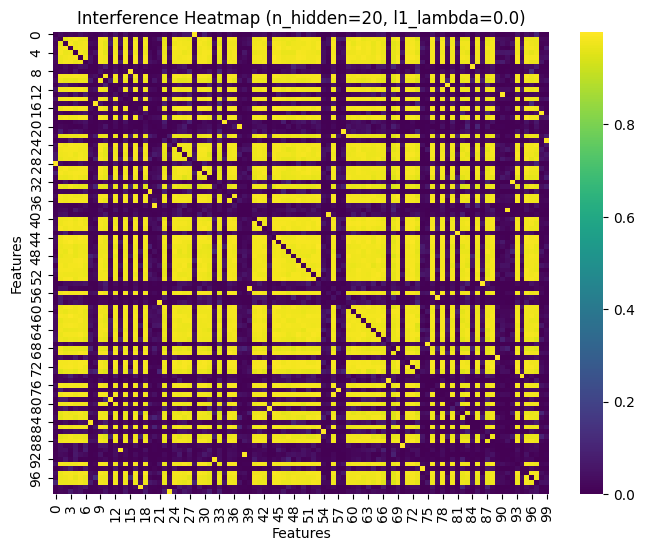

In [37]:
# Example: Visualize interference pattern for a specific model
# Select a model from results
selected_n_hidden = 20
selected_l1_lambda = 0.0
model_example = None

for l1_lambda in l1_lambda_list:
    for n_hidden in n_hidden_list:
        if n_hidden == selected_n_hidden and l1_lambda == selected_l1_lambda:
            config = Config(
                n_features=n_features,
                n_hidden=n_hidden,
                n_instances=1,
            )
            feature_probability = torch.ones((n_features,), device=DEVICE) * 0.5
            importance = torch.ones((n_features,), device=DEVICE)
            model_example = Model(
                config=config,
                device=DEVICE,
                feature_probability=feature_probability,
                importance=importance,
            )
            optimize(model_example, steps=5000, lr=1e-3, l1_lambda=l1_lambda)
            break

if model_example is not None:
    plot_interference_heatmap(model_example, title=f'Interference Heatmap (n_hidden={selected_n_hidden}, l1_lambda={selected_l1_lambda})')

In [15]:
import pandas as pd

df_results = pd.DataFrame(results)
print("\nResults:")
print(df_results)


Results:
   n_hidden    loss_clean  loss_adv  superposition
0        20  7.806541e-02  0.079578        0.38701
1       120  1.224091e-09  0.007151        0.00001


so we see that fewer number of hidden units (with superposition) has a loss of (0.07806 lossclean and 0.0795 loss adversarial)

while the model with more hidden units (no superposition) has a loss of (1.22e-09 loss clean and 0.007151 loss adversarial)

the avg interference (superposition measurement) is higher in the model with fewer hidden units (the model with superposition), indicating that the features are more interfering with each other.


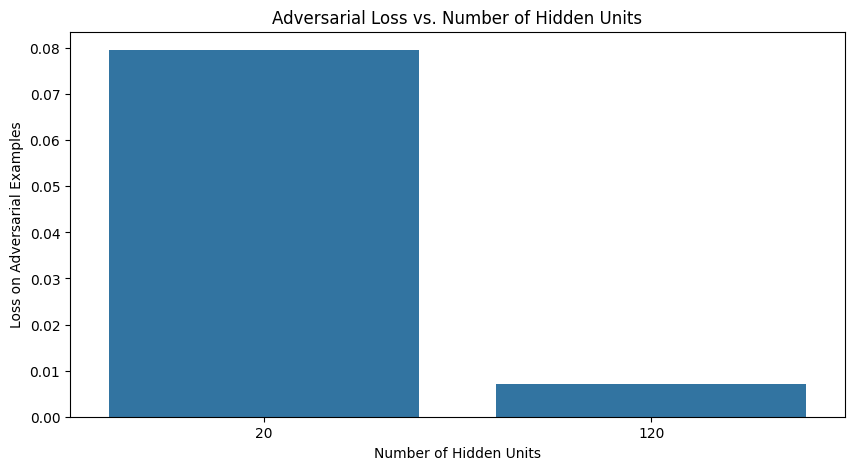

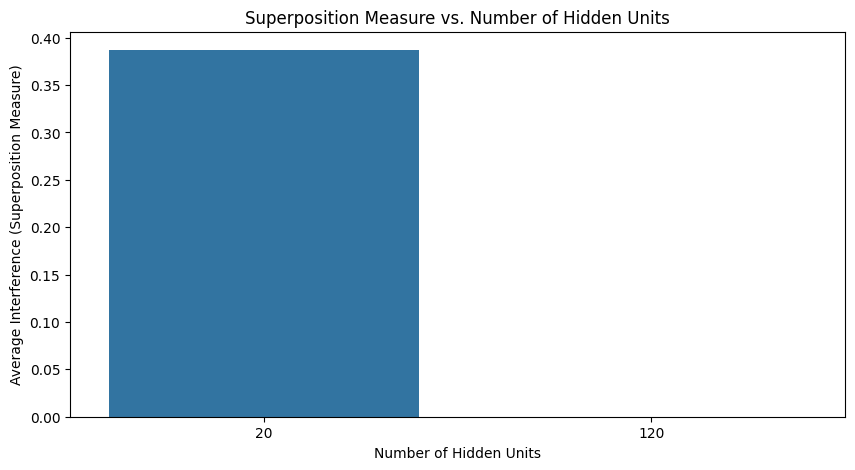

In [16]:
# Plotting the results
plt.figure(figsize=(10, 5))
sns.barplot(x='n_hidden', y='loss_adv', data=df_results)
plt.title('Adversarial Loss vs. Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Loss on Adversarial Examples')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='n_hidden', y='superposition', data=df_results)
plt.title('Superposition Measure vs. Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Interference (Superposition Measure)')
plt.show()